# iphone2Vec

© Yuriy Guts, 2016

Using the text kindly compiled by Eugene Yuen

#### Note: Converted to run on Python 3 and gensim-3.4.0


## Imports

In [1]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [2]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [5]:
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabrielmanuelsidik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielmanuelsidik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Prepare Corpus

**Load books from files**

In [6]:
book_filenames = sorted(glob.glob("data/iphone.txt"))


In [7]:
print("Found books:")
print(book_filenames)

Found books:
['data/iphone.txt']


**Combine the books into one string**

In [8]:
corpus_raw = u""
print("corpus_raw", corpus_raw)
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

corpus_raw 
Reading 'data/iphone.txt'...
Corpus is now 507121 characters long



**Split the corpus into sentences**

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
raw_sentences = tokenizer.tokenize(corpus_raw)
# raw_sentences = raw_sentences[0].split("\n")
print(raw_sentences)

['Turn on iPhone.', 'Press and hold the side button or Sleep/Wake button (depending on your model) until the Apple logo appears.', 'If iPhone doesnt turn on, you might need to charge and monitor the battery.', 'Turn off iPhone.', 'Normally, you leave iPhone on all of the time, but if you need to turn it off, go to Settings > General > Shut Down.', 'If you were given a SIM card to install, install it before setting up iPhone.', 'Important: A Nano-SIM card is required to use cellular services when connecting to GSM networks and some CDMA networks.', 'An iPhone activated on a CDMA wireless network can also use a Nano-SIM card for connecting to a GSM network, primarily for international roaming.', 'Your iPhone is subject to your wireless service provider�s policies, which might include restrictions on switching service providers and roaming, even after the conclusion of any required minimum service contract.', 'Contact your wireless service provider for more details.', 'Availability of cel

In [11]:
#convert into a list of words
#remove unnecessary,, split into words, no hyphens
#list of words

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    filtered_words = []
    
    for word in words:
        if word not in stop_words:
            filtered_words.append(word)
    
    return filtered_words

In [12]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [16]:
print(raw_sentence)
print(sentence_to_wordlist(raw_sentence))
print(sentences[-1])

Dispose of batteries according to your local environmental laws and guidelines.
['Dispose', 'batteries', 'according', 'local', 'environmental', 'laws', 'guidelines']
['Dispose', 'batteries', 'according', 'local', 'environmental', 'laws', 'guidelines']


In [17]:
token_count = sum([len(sentence) for sentence in sentences])
print("The song corpus contains {0:,} tokens".format(token_count))

The song corpus contains 56,022 tokens


## Train Word2Vec

In [18]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 1

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [19]:
iphone2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [20]:
iphone2vec.build_vocab(sentences)

2018-08-06 21:08:29,728 : INFO : collecting all words and their counts
2018-08-06 21:08:29,730 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-08-06 21:08:29,748 : INFO : collected 5015 word types from a corpus of 56022 raw words and 6944 sentences
2018-08-06 21:08:29,749 : INFO : Loading a fresh vocabulary
2018-08-06 21:08:29,760 : INFO : min_count=1 retains 5015 unique words (100% of original 5015, drops 0)
2018-08-06 21:08:29,761 : INFO : min_count=1 leaves 56022 word corpus (100% of original 56022, drops 0)
2018-08-06 21:08:29,777 : INFO : deleting the raw counts dictionary of 5015 items
2018-08-06 21:08:29,778 : INFO : sample=0.001 downsamples 48 most-common words
2018-08-06 21:08:29,784 : INFO : downsampling leaves estimated 49880 word corpus (89.0% of prior 56022)
2018-08-06 21:08:29,806 : INFO : estimated required memory for 5015 words and 300 dimensions: 14543500 bytes
2018-08-06 21:08:29,807 : INFO : resetting layer weights


In [21]:
print("Word2Vec vocabulary length:", len(iphone2vec.wv.vocab))

Word2Vec vocabulary length: 5015


**Start training, this might take a minute or two...**

In [22]:
iphone2vec.train(sentences, total_examples=iphone2vec.corpus_count, epochs=10)

2018-08-06 21:08:34,558 : INFO : training model with 4 workers on 5015 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-08-06 21:08:34,753 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-08-06 21:08:34,755 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-08-06 21:08:34,844 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-08-06 21:08:34,877 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-08-06 21:08:34,879 : INFO : EPOCH - 1 : training on 56022 raw words (49914 effective words) took 0.3s, 161532 effective words/s
2018-08-06 21:08:35,056 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-08-06 21:08:35,062 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-08-06 21:08:35,159 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-08-06 21:08:35,236 : INFO : worker thread finished; awaiting finish of 0 mor

(499027, 560220)

**Save to file, can be useful later**

In [23]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [24]:
iphone2vec.save(os.path.join("trained", "iphone2vec.w2v"))

2018-08-06 21:08:43,383 : INFO : saving Word2Vec object under trained/iphone2vec.w2v, separately None
2018-08-06 21:08:43,385 : INFO : not storing attribute vectors_norm
2018-08-06 21:08:43,387 : INFO : not storing attribute cum_table
2018-08-06 21:08:43,531 : INFO : saved trained/iphone2vec.w2v


## Explore the trained model.

In [25]:
iphone2vec = w2v.Word2Vec.load(os.path.join("trained", "iphone2vec.w2v"))

2018-08-06 21:08:45,083 : INFO : loading Word2Vec object from trained/iphone2vec.w2v
2018-08-06 21:08:45,190 : INFO : loading wv recursively from trained/iphone2vec.w2v.wv.* with mmap=None
2018-08-06 21:08:45,191 : INFO : setting ignored attribute vectors_norm to None
2018-08-06 21:08:45,192 : INFO : loading vocabulary recursively from trained/iphone2vec.w2v.vocabulary.* with mmap=None
2018-08-06 21:08:45,193 : INFO : loading trainables recursively from trained/iphone2vec.w2v.trainables.* with mmap=None
2018-08-06 21:08:45,194 : INFO : setting ignored attribute cum_table to None
2018-08-06 21:08:45,198 : INFO : loaded trained/iphone2vec.w2v


### Compress the word vectors into 2D space and plot them

In [26]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [27]:
all_word_vectors_matrix = iphone2vec.wv.vectors

**Train t-SNE, this could take a minute or two...**

In [29]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [30]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[iphone2vec.wv.vocab[word].index])
            for word in iphone2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [31]:
points.head(10)

,word,x,y
0,Turn,76.046288,4.338122
1,iPhone,60.063625,-24.396639
2,Press,30.795519,61.109619
3,hold,28.381863,60.946590
4,side,31.332827,61.050808
5,button,46.748386,38.431419
6,Sleep,31.271185,61.062767
7,Wake,31.345306,61.065434
8,depending,32.604591,61.341747
9,model,32.529602,61.317924


In [32]:
sns.set_context("poster")

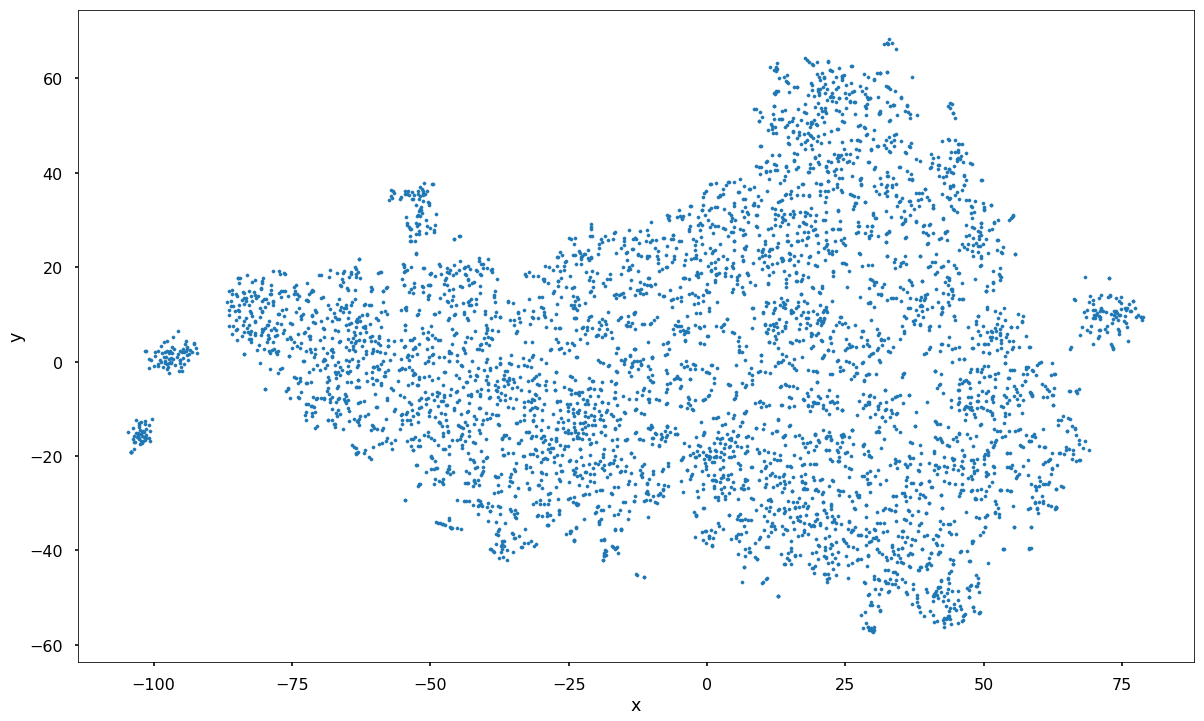

In [33]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [34]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, c=None, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**Found the House Mottos!**

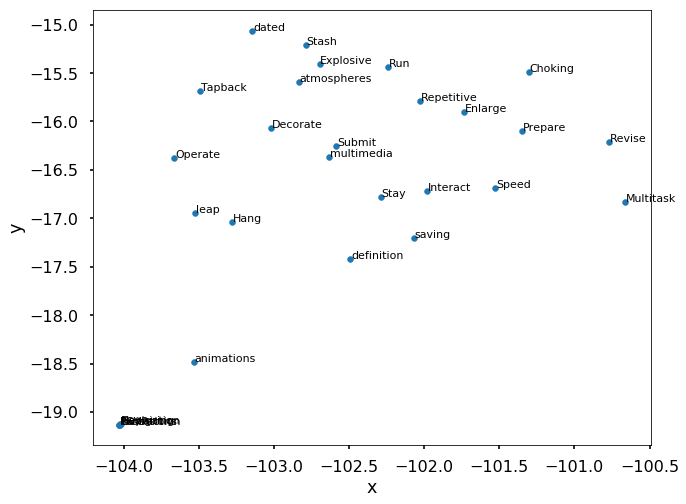

In [47]:
plot_region(x_bounds=(-110, -95), y_bounds=(-20, -15))

**Can't find anything particularly interesting anymore :(**

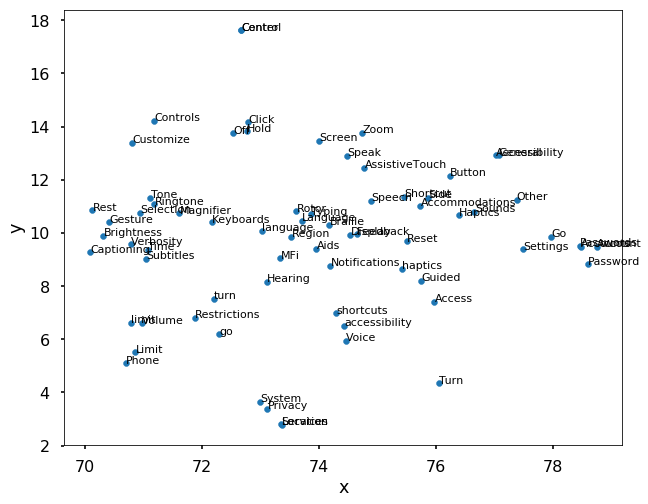

In [48]:
plot_region(x_bounds=(70, 80), y_bounds=(0, 20))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [ ]:
iphone2vec.wv.most_similar("power")

In [ ]:
iphone2vec.wv.most_similar("Internet")

In [ ]:
iphone2vec.wv.most_similar("music")

**Linear relationships between word pairs**

In [ ]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = iphone2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [ ]:
nearest_similarity_cosmul("screen", "brightness", "loud")

# Time to use this data and model to create the bins

	iterating through each word:
		bin them into similar clusters (threshold of similarity can be set [see: cosine distance against the average word] via a greedy algorithm or k-means clustering)
		{Note: greedy would be O(n^2) complexity, where n is the number of words in the total text}
		Keep tally as well of the categories each sentence has words falling into. (Still O(N^2))
	
	Resulting output include:
        1. 2-D array of sentences - categories
        2. 2-D array of categories - words
        3. 2-D array of categories - sentences
    1. All these can be made in O(n) if greedy is used.

In [49]:
iphone2vec.wv.similarity("listen", "play")

0.8627110513276685

In [50]:
iphone2vec.wv.similarity("listen", "network")

0.5592499472059876

In [51]:
iphone2vec.wv.similarity("listen", "library")

0.8893929811910445

In [52]:
iphone2vec.wv.similarity("listen", "songs")

0.9340747170179385

In [54]:
iphone2vec.wv.similarity("turn", "songs")

0.34505886144369163

In [55]:
iphone2vec.wv.similarity("songs", "iPhone")

0.30371808248231896

In [56]:
print(iphone2vec.wv.get_vector("speaker"))

[ 0.09138726 -0.12688835  0.06392576  0.16833603 -0.01441696  0.001405
 -0.14730418 -0.01617131 -0.07757764 -0.02215859  0.0561998   0.05600089
 -0.01019708  0.03069012 -0.00349108  0.12405481 -0.08168692 -0.13561988
  0.20013614  0.01664956  0.01329044  0.04992769 -0.02156404 -0.25627548
  0.15609013 -0.04381884 -0.05252175  0.01164455 -0.00928484  0.00356979
 -0.11866297 -0.04041503 -0.17012787 -0.09833072 -0.02213548 -0.06215706
 -0.04107986  0.03796232  0.21109658  0.00788549  0.01409813  0.03044564
 -0.02136244  0.0344496  -0.20971248 -0.03433853  0.06088807 -0.16432804
 -0.07775826 -0.14749934  0.00460602  0.2395632   0.04385641 -0.11306419
 -0.12397824 -0.00387498  0.02850751 -0.15814297  0.03572964  0.03450253
 -0.03552184 -0.16257457  0.150477    0.06712113  0.1082466   0.04865048
 -0.09724417  0.08856133 -0.16756132  0.18592325 -0.14894597 -0.12168564
  0.00422317 -0.0472793   0.18254842 -0.04601121 -0.15534654 -0.05434357
 -0.15447861  0.15791808  0.07470851 -0.0756025  -0.1

In [57]:
class Category:
    
    def __init__(self, word, threshold = 0.9): 
        self.threshold = threshold
        self.words = set()
        self.words.add(word)
        self.num_of_words = 1
        self.average_vector = iphone2vec.wv.get_vector(word)
        self.average_word = word
        
    def add_word(self, word):
        if (word not in self.words):
            self.words.add(word)

            self.average_vector = (
                iphone2vec.wv.get_vector(word) 
                + self.average_vector * self.num_of_words
            )/(self.num_of_words + 1)

            self.average_word = iphone2vec.wv.similar_by_vector(self.average_vector, topn = 1)[0][0]

            self.num_of_words += 1
    
    def is_similar(self, word):
        return iphone2vec.wv.similarity(self.average_word, word) > self.threshold
    


In [58]:
test_category = Category("speaker")

In [59]:
test_set = {"one", "two"}

In [60]:
test_set.add("three")

In [61]:
test_set.add("one")

In [62]:
print(test_set)

{'one', 'three', 'two'}


In [63]:
test_category.add_word("sound")

In [65]:
print(test_category.words)
print(test_category.average_word)
print(test_category.is_similar('speakers'))

{'speaker', 'sound'}
countdown
False


In [45]:
categories = []
for sentence in sentences:
    for word in sentence:

        is_added = False

        for category in categories:
            if (category.is_similar(word)):
                category.add_word(word)
                is_added = True
                break

        if (not is_added):
            categories.append(Category(word, 0.95))
            

2018-08-06 21:17:16,994 : INFO : precomputing L2-norms of word weight vectors


In [46]:
for category in categories:
    print(category.words)

{'Turn'}
{'iPhone'}
{'Press'}
{'hold'}
{'Sleep', 'side', 'Wake', 'release', 'logo'}
{'button'}
{'model', 'depending'}
{'Apple'}
{'appears'}
{'If'}
{'temperature', 'months', 'DSLR', 'capacity', 'wiki', 'optimal', 'boarding', 'Lithium', 'dress', 'reward', 'head', 'Web', 'prolonged', 'Repetitive', 'Car', 'advertising', 'easy', 'Mutes', 'netmelig', 'report', 'Detects', 'zipline', 'earbuds', 'Long', 'blank', 'directrices', 'breaks', 'indicated', 'repellant', 'outline', 'Respond', 'insect', 'credentials', 'showering', 'tour', 'incinerate', 'question', 'passenger', 'visited', 'backs', 'Q', 'revert', 'ups', 'organ', 'mislabeled', 'distances', 'Legal', 'filename', 'During', 'hip', 'short', 'repeats', 'children', 'arithmetic', 'accepter', 'flag', 'Molly', 'deletes', 'reconnects', 'Split', 'publications', 'becoming', 'present', 'suggesting', 'attendees', 'mobile', 'dramatic', 'Restoring', 'interfering', 'salt', 'diretrizes', 'presentations', 'hidden', 'capitalization', 'eyestrain', 'removes', 'St